In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

from finder import read_files, parse_annotated, target_classes
from label import Label

In [2]:
SEED=12345
default_label = Label('Misc-exposition')
keep_labels = [Label('Description'), Label('Nomenclature')]

In [3]:
training_files = [f for g in [
    'data/annotated/journals/Mycotaxon/Vol*/*.ann'
] for f in glob.glob(g)]


In [4]:
paragraphs = list(parse_annotated(read_files(training_files)))

In [5]:
relabeled = list(target_classes(default=default_label, keep=keep_labels, paragraphs=paragraphs))

In [6]:
len(relabeled)

68371

In [7]:
df = pd.DataFrame({
    'filename': [pp.filename for pp in relabeled],
    'label': [pp.top_label().label if pp.top_label() else None for pp in relabeled],
    'paragraph_number': [pp.paragraph_number for pp in relabeled],
    'page_number': [pp.page_number for pp in relabeled],
    'empirical_page_number': [pp.empirical_page_number for pp in relabeled],
    'line_number': [pp.first_line.line_number if pp.first_line else None for pp in relabeled],
    'body': [str(pp) for pp in relabeled]
})
df.label = pd.Categorical(df.label)
df['label_code'] = df.label.cat.codes

In [8]:
df.describe()

,paragraph_number,page_number,line_number,label_code
count,68371.000000,68371.000000,68370.000000,68371.000000
mean,34185.000000,227.817657,31.739491,0.997514
std,19737.151964,195.701461,29.224756,0.316888
min,0.000000,0.000000,1.000000,0.000000
25%,17092.500000,16.000000,10.000000,1.000000
50%,34185.000000,208.000000,25.000000,1.000000
75%,51277.500000,411.000000,43.000000,1.000000
max,68370.000000,572.000000,292.000000,2.000000


In [9]:
df.keys()

Index(['filename', 'label', 'paragraph_number', 'page_number',
       'empirical_page_number', 'line_number', 'body', 'label_code'],
      dtype='object')

In [10]:
df.groupby('label').nunique()

,filename,label,paragraph_number,page_number,empirical_page_number,line_number,body,label_code
label,,,,,,,,
Description,148,1,3518,469,492,81,2610,1
Misc-exposition,168,1,61505,573,581,191,35051,1
Nomenclature,151,1,3348,411,443,82,3235,1


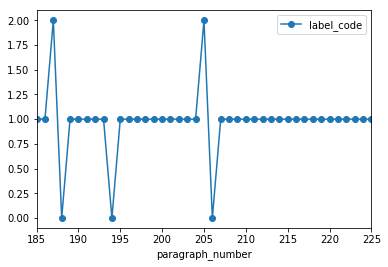

In [11]:
df.plot(kind='line', x='paragraph_number', y='label_code', style='-o')
x = 185
plt.xlim(x,x+40)
plt.show()

In [12]:
df.loc[187], df.loc[188], df.loc[194]

(filename                 data/annotated/journals/Mycotaxon/Vol119/s17.t...
 label                                                         Nomenclature
 paragraph_number                                                       187
 page_number                                                              4
 empirical_page_number                                                  152
 line_number                                                             17
 body                     Physcia phaea (Tuck.) J.W. Thomson, Beih. Nova...
 label_code                                                               2
 Name: 187, dtype: object,
 filename                 data/annotated/journals/Mycotaxon/Vol119/s17.t...
 label                                                          Description
 paragraph_number                                                       188
 page_number                                                              4
 empirical_page_number                                       

We're only interested in Nomeclature and Description paragraphs.

The long list of Nomenclatures followed by a single Nomenclature is an article with just Nomenclatures, and then the next article has a Nomenclature and two Descriptions.

In [13]:
df2 = df.loc[df['label'].isin(['Nomenclature', 'Description'])]
len(df2)

6866

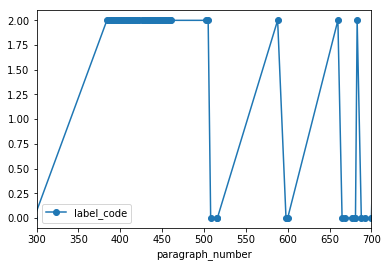

In [14]:
df2.plot(kind='line', x='paragraph_number', y='label_code', style='-o')
x = 300
plt.xlim(x,x+400)
plt.show()

Sensible cutoffs for max distance from Nomenclature to Description appear to be above 6 or maybe above 13.

3958.0

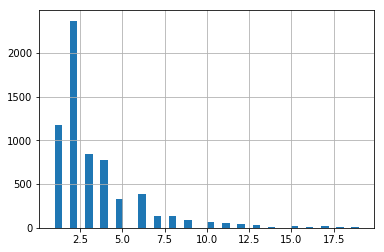

In [15]:
diffs = df2['paragraph_number'].diff()
diffs[diffs < 20].hist(bins=40)
diffs.max()

I have confirmed that the highest paragraph distance is the first nomenclature in a volume. The first and last few articles in Mycotaxon typically have no Nomenclatures.

In [16]:
df2.loc[diffs.index[diffs == 3958.0]]

,filename,label,paragraph_number,page_number,empirical_page_number,line_number,body,label_code
57414,data/annotated/journals/Mycotaxon/Vol057/n1.tx...,Nomenclature,57414,96,88,21.0,Appendiculella mauensis R. K. Mibey sp. nov. F...,2


In [18]:
df2.loc[57414]

filename                 data/annotated/journals/Mycotaxon/Vol057/n1.tx...
label                                                         Nomenclature
paragraph_number                                                     57414
page_number                                                             96
empirical_page_number                                                   88
line_number                                                             21
body                     Appendiculella mauensis R. K. Mibey sp. nov. F...
label_code                                                               2
Name: 57414, dtype: object

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import numpy as np
classifier = CalibratedClassifierCV()
vectorizer = TfidfVectorizer()
vectorize_text = vectorizer.fit_transform(df['body'])

pca = TruncatedSVD(n_components=1000)
vt2d = pca.fit_transform(vectorize_text)

sample = vectorizer.transform([df.loc[57413]['body']])
(sample, vectorize_text, vt2d)

(<1x66569 sparse matrix of type '<class 'numpy.float64'>'
 	with 0 stored elements in Compressed Sparse Row format>,
 <68371x66569 sparse matrix of type '<class 'numpy.float64'>'
 	with 765238 stored elements in Compressed Sparse Row format>,
 array([[-5.99562706e-18,  3.31524166e-16,  4.81917232e-15, ...,
         -1.31824513e-15, -1.99328481e-15, -9.16412873e-16],
        [ 2.23990154e-03,  1.04315089e-01,  1.68186225e-02, ...,
          4.77310757e-05,  1.20496157e-04,  5.01271672e-04],
        [-3.76671078e-18, -1.41452299e-15,  1.12163158e-15, ...,
          9.32460882e-16, -2.13482295e-15, -2.91093710e-16],
        ...,
        [ 3.89503800e-02,  3.76054558e-04,  2.54600130e-03, ...,
          2.40028896e-02,  7.72857508e-03,  1.31438096e-03],
        [ 3.20905536e-03,  6.83357336e-04, -1.28874410e-04, ...,
          2.24489106e-02,  1.41850327e-02,  5.16306814e-02],
        [ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00,  0.000

In [ ]:
pca.components_

In [ ]:
pca.explained_variance_ratio_

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
cumsum